In [7]:
from ml_aos.dataloader import Donuts
from ml_aos.david_net import WaveNet

import torch
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load a small training set that we are going to overfit
donuts = DataLoader(
    Donuts("test", ntest=10), 
    batch_size=10, 
    shuffle=False, 
    pin_memory=True,
)

In [13]:
model = WaveNet(3)

optimizer = Adam(model.parameters(), lr=3e-4)
loss_fn = MSELoss()

torch.manual_seed(0)
torch.cuda.manual_seed(0)

model.train()
device = "cuda:0"
model.cuda(device)

WaveNet(
  (donut_net): DonutNet(
    (layers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): DownBlock(
        (layers): ModuleList(
          (0): SkipBlock(
            (layers): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
        )
      )
      (4): DownBlock(
        (layers): ModuleList(
          (0): SkipBlock(
            (layers): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3

In [14]:
losses = []

for epoch in range(10_000):
    
    for i, donut in enumerate(donuts):

        # load data and transfer to GPU
        img = donut["image"].cuda(device)
        zernikes = donut["zernikes"].cuda(device)
        fx = donut["field_x"].cuda(device)
        fy = donut["field_y"].cuda(device)
        intra = donut["intrafocal"].cuda(device)

        # allow gradients wrt these values
        img.requires_grad = True
        zernikes.requires_grad = True
        fx.requires_grad = True
        fy.requires_grad = True
        intra.requires_grad = True

        # forward pass
        out = model(img, fx, fy, intra)
        loss = loss_fn(out, zernikes)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(np.mean(loss.data.cpu().numpy()))
    

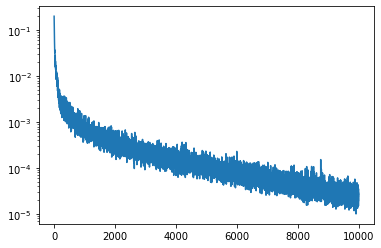

In [16]:
plt.plot(losses)
plt.yscale("log")

In [17]:
model.eval()

img = donut["image"].cuda(device)
zernikes = donut["zernikes"].cuda(device)
fx = donut["field_x"].cuda(device)
fy = donut["field_y"].cuda(device)
intra = donut["intrafocal"].cuda(device)

out = model(img, fx, fy, intra)

model.train()

WaveNet(
  (donut_net): DonutNet(
    (layers): ModuleList(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): DownBlock(
        (layers): ModuleList(
          (0): SkipBlock(
            (layers): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU(inplace=True)
        )
      )
      (4): DownBlock(
        (layers): ModuleList(
          (0): SkipBlock(
            (layers): Sequential(
              (0): Conv2d(16, 16, kernel_size=(3, 3

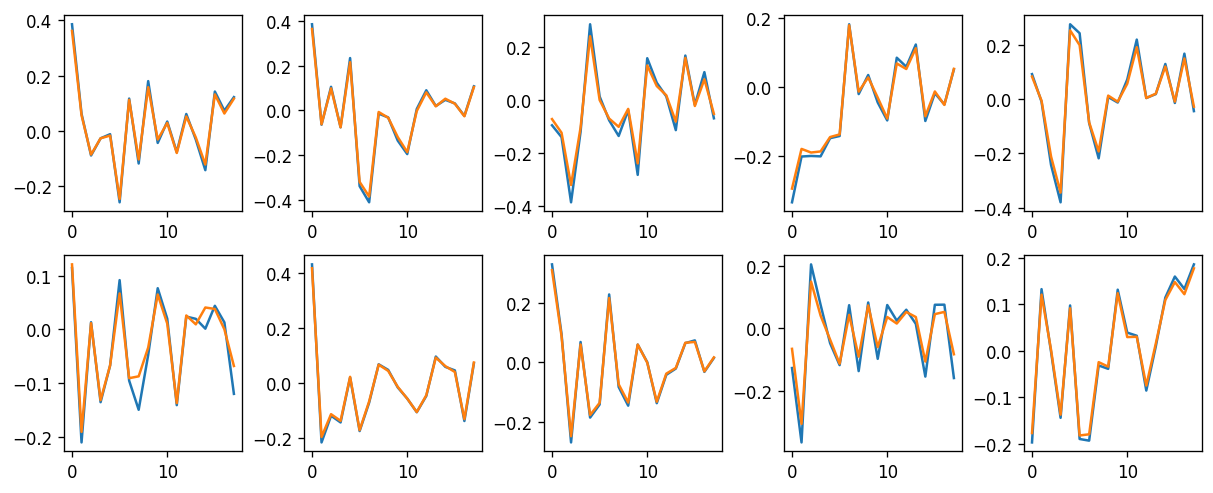

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):

    ax.plot(zernikes[i].detach().cpu())
    ax.plot(out[i].detach().cpu())

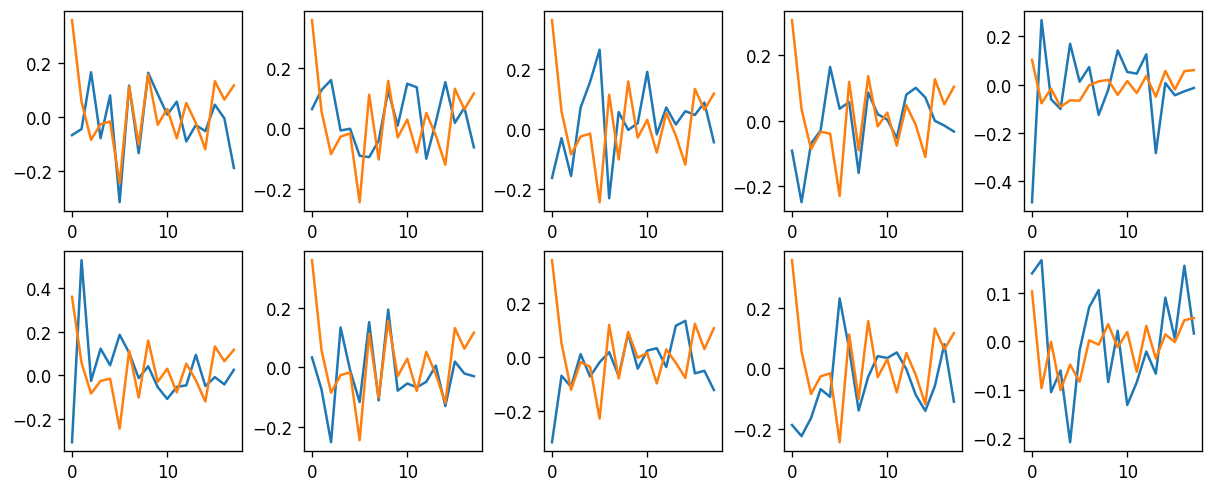

In [21]:
other_donuts = DataLoader(
    Donuts("test", ntest=10, seed=123), 
    batch_size=10, 
    shuffle=False, 
    pin_memory=True,
)

for donut in other_donuts:
    pass

model.eval()

img = donut["image"].cuda(device)
zernikes = donut["zernikes"].cuda(device)
fx = donut["field_x"].cuda(device)
fy = donut["field_y"].cuda(device)
intra = donut["intrafocal"].cuda(device)

out = model(img, fx, fy, intra)

model.train()

fig, axes = plt.subplots(2, 5, figsize=(10, 4), dpi=120, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):

    ax.plot(zernikes[i].detach().cpu())
    ax.plot(out[i].detach().cpu())